In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt 
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.ar_model import AutoReg
from datetime import datetime,time

from statsmodels.tools.eval_measures import mse,rmse

from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

In [4]:
def adf_test(series,title=''):
    
 #   Pass in a time series and an optional title, returns an ADF report
    
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [5]:
df = pd.read_csv('Beds_Occupied - Beds_Occupied.csv',parse_dates=True)
df.head(30)

,collection_date,Total Inpatient Beds
0,15-06-2020,293
1,16-06-2020,295
2,17-06-2020,290
3,18-06-2020,291
4,19-06-2020,288
5,20-06-2020,289
6,21-06-2020,277
7,22-06-2020,289
8,23-06-2020,292
9,24-06-2020,293


In [6]:
df.dtypes

collection_date         object
Total Inpatient Beds     int64
dtype: object

In [7]:
df['collection_date'] = pd.to_datetime(df['collection_date'],format='%d-%m-%Y')

In [8]:
df.head(30)

,collection_date,Total Inpatient Beds
0,2020-06-15,293
1,2020-06-16,295
2,2020-06-17,290
3,2020-06-18,291
4,2020-06-19,288
5,2020-06-20,289
6,2020-06-21,277
7,2020-06-22,289
8,2020-06-23,292
9,2020-06-24,293


In [9]:
df.dtypes

collection_date         datetime64[ns]
Total Inpatient Beds             int64
dtype: object

In [10]:
df.index = df['collection_date']

In [11]:
df = df.asfreq('d')

In [12]:
df.drop('collection_date',inplace=True,axis=1)

In [13]:
df.isnull().sum()

Total Inpatient Beds    7
dtype: int64

In [14]:
null_data = df[df.isnull().any(axis=1)]

In [15]:
null_data

,Total Inpatient Beds
collection_date,
2020-11-26,NaN
2020-11-27,NaN
2020-11-28,NaN
2020-11-29,NaN
2021-05-14,NaN
2021-05-15,NaN
2021-05-16,NaN


In [16]:
span = 14
alpha = 2/(span+1)

df['EWMA'] = df['Total Inpatient Beds'].ewm(alpha=alpha,adjust=False).mean()

In [17]:
null_data = df[df.isnull().any(axis=1)]

null_data

,Total Inpatient Beds,EWMA
collection_date,,
2020-11-26,NaN,235.091316
2020-11-27,NaN,235.091316
2020-11-28,NaN,235.091316
2020-11-29,NaN,235.091316
2021-05-14,NaN,235.267330
2021-05-15,NaN,235.267330
2021-05-16,NaN,235.267330


In [18]:
df['Total Inpatient Beds'] = df['Total Inpatient Beds'].fillna(df.EWMA)

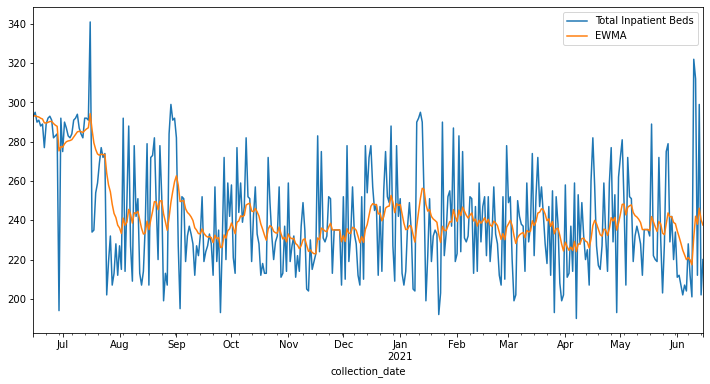

In [19]:
df.plot(legend=True,figsize=(12,6));

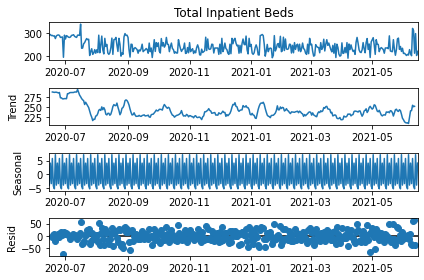

In [20]:
result = seasonal_decompose(df['Total Inpatient Beds'])
result.plot();

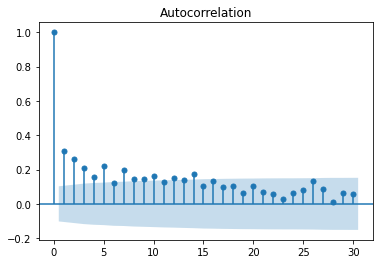

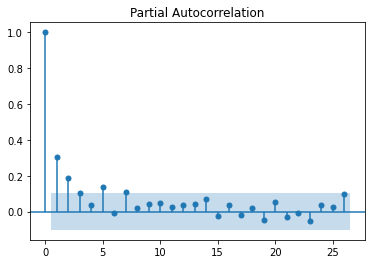

In [21]:
tsa_plots.plot_acf(df['Total Inpatient Beds'],lags=30);
tsa_plots.plot_pacf(df['Total Inpatient Beds']);

In [22]:
adf_test(df['Total Inpatient Beds'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -5.809918e+00
p-value                 4.426037e-07
# lags used             4.000000e+00
# observations          3.610000e+02
critical value (1%)    -3.448595e+00
critical value (5%)    -2.869580e+00
critical value (10%)   -2.571053e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [23]:
df['Availability'] = 900-df['Total Inpatient Beds']

In [24]:
df.head()

,Total Inpatient Beds,EWMA,Availability
collection_date,,,
2020-06-15,293.0,293.000000,607.0
2020-06-16,295.0,293.266667,605.0
2020-06-17,290.0,292.831111,610.0
2020-06-18,291.0,292.586963,609.0
2020-06-19,288.0,291.975368,612.0


In [25]:
auto_arima(df['Total Inpatient Beds'],seasonal=False,stationary=True,trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3450.235, Time=3.77 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3498.228, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3463.937, Time=0.29 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3474.190, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5063.215, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3454.112, Time=1.29 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3453.529, Time=1.27 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3449.950, Time=2.96 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3452.634, Time=1.26 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=3456.210, Time=3.48 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=3445.001, Time=2.91 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=3450.540, Time=1.89 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=3444.856, Time=2.81 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=3448.073, Time=3.30 sec
 ARIMA(4,0,4)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(5, 0, 3)   Log Likelihood               -1711.922
Date:                Wed, 25 Aug 2021   AIC                           3441.844
Time:                        11:58:21   BIC                           3476.968
Sample:                             0   HQIC                          3455.801
                                - 366                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7620      0.055    -13.880      0.000      -0.870      -0.654
ar.L2          1.1348      0.070     16.100      0.000       0.997       1.273
ar.L3          0.9378      0.067     14.019      0.000       0.807       1.069
ar.L4         -0.2047      0.069     -2.954      0.003      -0.340      -0.069
ar.L5         -0.1060      0.054     -1.968      0.049      -0.212      -0.000
ma.L1          0.9803      0.030     32.879      0.000       0.922       1.039
ma.L2         -0.8295      0.036    -23.159      0.000      -0.900      -0.759
ma.L3         -0.9222      0.030    -31.101      0.000      -0.980      -0.864
sigma2       662.8360     45.571     14.545      0.000     573.519     752.153
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                16.54
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.35
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
# train=df.head(len(df)-30)
# test = df.tail(30)
train=df.head(int(len(df)*0.67))
test = df.iloc[len(train):]

In [27]:
auto_arima(train['Total Inpatient Beds'],seasonal=False,trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2291.491, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2397.873, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2341.686, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2290.888, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2395.888, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2288.952, Time=0.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2289.573, Time=0.47 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2292.756, Time=0.69 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2289.588, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2324.452, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2288.109, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2289.667, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2339.718, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2288.870, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  245
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1141.054
Date:                Wed, 25 Aug 2021   AIC                           2288.109
Time:                        11:58:28   BIC                           2298.600
Sample:                             0   HQIC                          2292.334
                                - 245                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1431      0.064      2.250      0.024       0.018       0.268
ma.L1         -0.9007      0.028    -32.571      0.000      -0.955      -0.847
sigma2       671.3273     58.230     11.529      0.000     557.199     785.455
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 2.25
Prob(Q):                              0.79   Prob(JB):                         0.33
Heteroskedasticity (H):               0.83   Skew:                             0.16
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
model = SARIMAX(train['Total Inpatient Beds'],order=(1,1,1))
results = model.fit()


In [29]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARIMA Predictions')

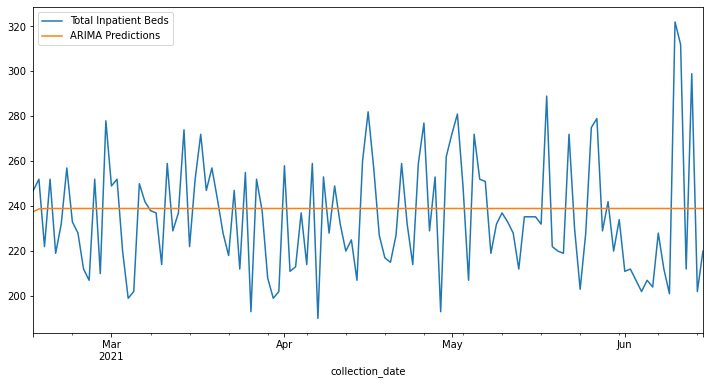

In [30]:
ax = test['Total Inpatient Beds'].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
# ax.set(xlabel=xlabel, ylabel=ylabel);

In [31]:
rmse(test['Total Inpatient Beds'],predictions)

26.025036295605666

### Residual Model

In [32]:
series=df.iloc[:,0]

In [33]:
# create lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']

# split into train and test sets
X = dataframe.values
train_size = int(len(X) * 0.67)
train_res, test_res = X[1:train_size], X[train_size:]
train_X, train_y = train_res[:,0], train_res[:,1]
test_X, test_y = test_res[:,0], test_res[:,1]

# persistence model on training set
# train_pred = [x for x in train_X]

# calculate residuals
train_resid = [train_y[i]-train_X[i] for i in range(len(train_X))] #difference between both columns

In [34]:
len(test_res)

121

In [35]:
len(test)

121

In [36]:
window = 15
model = AutoReg(train_resid, lags=15)
model_fit = model.fit()
coef = model_fit.params

In [37]:
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
# history = [history[i] for i in range(len(history))]
predictions_res = list()
for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]  # actual data or data at time 't'
    error = test_y[t] - yhat  #difference between time at 't' and 't+1'
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    # correct the prediction
    yhat = yhat + pred_error
    predictions_res.append(yhat)
    history.append(error)
#     print('predicted=%f, expected=%f' % (yhat, test_y[t]))

rmse_data = rmse(test_y, predictions_res)
print(f"rmse {rmse_data}") 

rmse 27.691608998082614


In [38]:
len(predictions)

121

In [39]:
len(predictions_res)

121

In [40]:
forecast = predictions + history[-121:]

In [41]:
rmse(test['Total Inpatient Beds'],forecast)

25.97541659830227

In [42]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [43]:
mean_absolute_percentage_error(test['Total Inpatient Beds'],forecast)

9.084820414071306

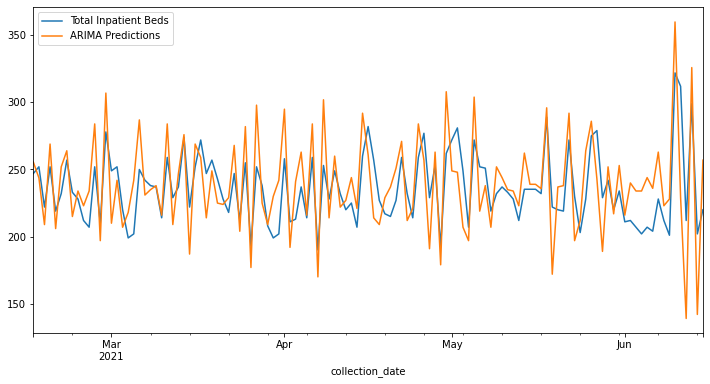

In [44]:
test['Total Inpatient Beds'].plot(legend=True);
forecast.plot(figsize=(12,6),legend=True);

### Last 30 days testing

In [45]:
# train=df.head(len(df)-30)
# test = df.tail(30)
train=df.head(336)
test = df.tail(30)

auto_arima(train['Total Inpatient Beds'],seasonal=False,trace=True).summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3124.165, Time=2.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3283.956, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3198.469, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3121.418, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3281.965, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3120.269, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3120.302, Time=0.66 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3123.743, Time=1.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3120.784, Time=0.73 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3177.450, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3119.438, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3120.313, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3196.497, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3119.631, Time=0.78 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  336
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1556.719
Date:                Wed, 25 Aug 2021   AIC                           3119.438
Time:                        12:00:09   BIC                           3130.880
Sample:                             0   HQIC                          3124.000
                                - 336                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1077      0.054      1.998      0.046       0.002       0.213
ma.L1         -0.9080      0.022    -41.324      0.000      -0.951      -0.865
sigma2       633.5774     48.662     13.020      0.000     538.201     728.953
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 1.20
Prob(Q):                              0.81   Prob(JB):                         0.55
Heteroskedasticity (H):               0.70   Skew:                             0.13
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
model = SARIMAX(train['Total Inpatient Beds'],order=(1,1,1))
results = model.fit()

In [47]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARIMA Predictions')

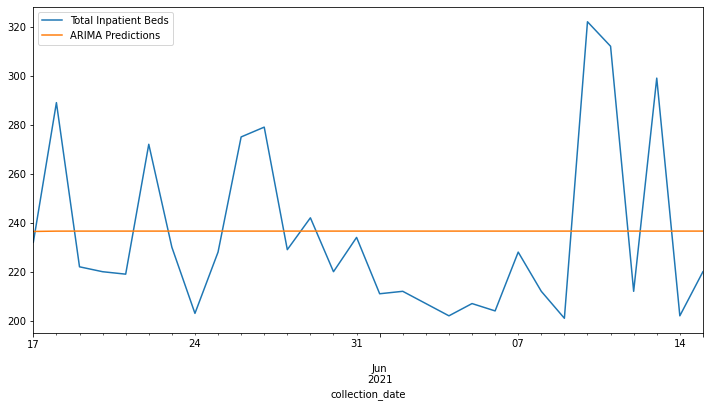

In [48]:
ax = test['Total Inpatient Beds'].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
# ax.set(xlabel=xlabel, ylabel=yla

In [49]:
rmse(test['Total Inpatient Beds'],predictions)

34.58000391490232

In [50]:
series=df.iloc[:,0]
# create lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']

In [51]:
X = dataframe.values

In [54]:
X[1]

array([293., 295.])

In [59]:
train_size = 336
train_res, test_res = X[1:train_size], X[train_size:]
train_X, train_y = train_res[:,0], train_res[:,1]
test_X, test_y = test_res[:,0], test_res[:,1]

In [60]:
# calculate residuals
train_resid = [train_y[i]-train_X[i] for i in range(len(train_X))] #difference between both columns

len(test_res)


30

In [61]:
len(test)

30

In [62]:
window = 15
model = AutoReg(train_resid, lags=15)
model_fit = model.fit()
coef = model_fit.params


In [63]:
# walk forward over time steps in test
history = train_resid[len(train_resid)-window:]
# history = [history[i] for i in range(len(history))]
predictions_res = list()
for t in range(len(test_y)):
    # persistence
    yhat = test_X[t]  # actual data or data at time 't'
    error = test_y[t] - yhat  #difference between time at 't' and 't+1'
    # predict error
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    pred_error = coef[0]
    for d in range(window):
        pred_error += coef[d+1] * lag[window-d-1]
    # correct the prediction
    yhat = yhat + pred_error
    predictions_res.append(yhat)
    history.append(error)
#     print('predicted=%f, expected=%f' % (yhat, test_y[t]))

rmse_data = rmse(test_y, predictions_res)
print(f"rmse {rmse_data}") 

rmse 37.96084020261823


In [64]:
len(predictions)

30

In [65]:
len(predictions_res)

30

In [66]:
forecast = predictions + history[-30:]

rmse(test['Total Inpatient Beds'],forecast)

34.44789800838541

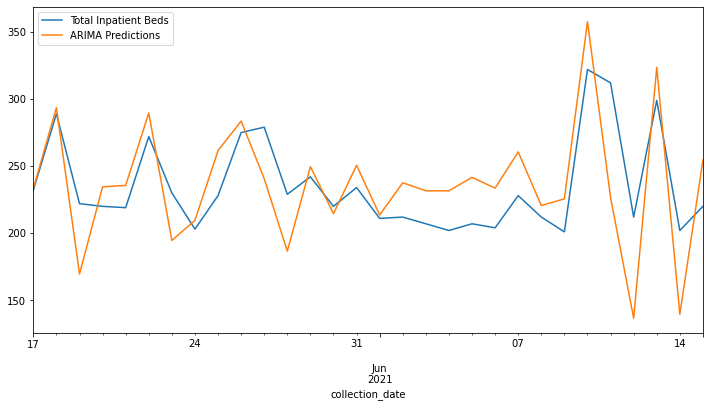

In [67]:
test['Total Inpatient Beds'].plot(legend=True);
forecast.plot(figsize=(12,6),legend=True);

### After Removing Outlier

<AxesSubplot:xlabel='Total Inpatient Beds'>

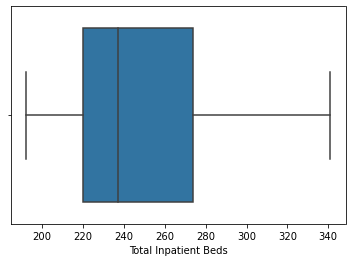

In [46]:
sns.boxplot(train['Total Inpatient Beds'])

<AxesSubplot:xlabel='Total Inpatient Beds'>

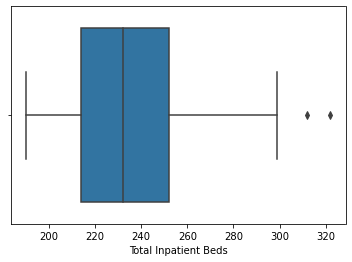

In [47]:
sns.boxplot(test['Total Inpatient Beds'])

<AxesSubplot:xlabel='Total Inpatient Beds'>

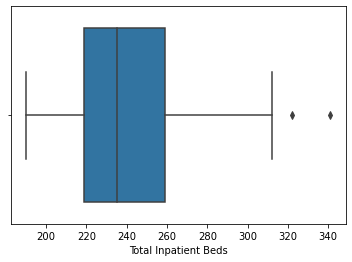

In [48]:
sns.boxplot(df['Total Inpatient Beds'])

### RNN

train = df[['Total Inpatient Beds']].head(346)
test = df[['Total Inpatient Beds']].tail(30)

In [49]:
train

,Total Inpatient Beds,EWMA,Availability
collection_date,,,
2020-06-15,293.0,293.000000,607.0
2020-06-16,295.0,293.266667,605.0
2020-06-17,290.0,292.831111,610.0
2020-06-18,291.0,292.586963,609.0
2020-06-19,288.0,291.975368,612.0
...,...,...,...
2021-02-10,213.0,239.619443,687.0
2021-02-11,247.0,240.603517,653.0
2021-02-12,214.0,237.056381,686.0


In [50]:
from sklearn.preprocessing import MinMaxScaler

In [56]:
scaler= MinMaxScaler()

In [59]:
new_train = train[['Total Inpatient Beds']]
new_test = test[['Total Inpatient Beds']]

In [61]:
scaled_train = scaler.fit_transform(new_train)
scaled_test = scaler.transform(new_test)

In [62]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [63]:
n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [64]:
len(generator)

238

In [65]:
X,y = generator[0]

In [66]:
scaled_train

array([[0.67785235],
       [0.69127517],
       [0.65771812],
       [0.66442953],
       [0.6442953 ],
       [0.65100671],
       [0.5704698 ],
       [0.65100671],
       [0.67114094],
       [0.67785235],
       [0.66442953],
       [0.60402685],
       [0.61073826],
       [0.61744966],
       [0.01342282],
       [0.67114094],
       [0.55704698],
       [0.65771812],
       [0.63758389],
       [0.61073826],
       [0.60402685],
       [0.61744966],
       [0.66442953],
       [0.67114094],
       [0.68456376],
       [0.63758389],
       [0.61744966],
       [0.60402685],
       [0.67114094],
       [0.67114094],
       [0.66442953],
       [1.        ],
       [0.28187919],
       [0.2885906 ],
       [0.41610738],
       [0.44966443],
       [0.51677852],
       [0.5704698 ],
       [0.53691275],
       [0.55033557],
       [0.06711409],
       [0.18120805],
       [0.26845638],
       [0.10067114],
       [0.1409396 ],
       [0.24161074],
       [0.13422819],
       [0.234

In [67]:
X

array([[[0.67785235],
        [0.69127517],
        [0.65771812],
        [0.66442953],
        [0.6442953 ],
        [0.65100671],
        [0.5704698 ]]])

In [68]:
y

array([[0.65100671]])

In [69]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [70]:
n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [71]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(36, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [72]:
model.fit_generator(generator,epochs=20)

Epoch 1/20
238/238 [==============================] - 46s 7ms/step - loss: 0.0543
Epoch 2/20
238/238 [==============================] - 1s 6ms/step - loss: 0.0285
Epoch 3/20
238/238 [==============================] - 2s 7ms/step - loss: 0.0350
Epoch 4/20
238/238 [==============================] - 1s 6ms/step - loss: 0.0334
Epoch 5/20
238/238 [==============================] - 1s 6ms/step - loss: 0.0313
Epoch 6/20
238/238 [==============================] - 1s 6ms/step - loss: 0.0334
Epoch 7/20
238/238 [==============================] - 1s 6ms/step - loss: 0.0323
Epoch 8/20
238/238 [==============================] - 2s 6ms/step - loss: 0.0387
Epoch 9/20
238/238 [==============================] - 1s 6ms/step - loss: 0.0303
Epoch 10/20
238/238 [==============================] - 1s 6ms/step - loss: 0.0309
Epoch 11/20
238/238 [==============================] - 1s 6ms/step - loss: 0.0364
Epoch 12/20
238/238 [==============================] - 1s 6ms/step - loss: 0.0308
Epoch 13/20
238/238 [===

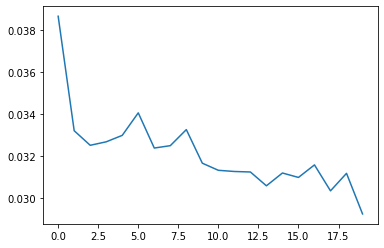

In [73]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [74]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [75]:
current_batch.shape

(1, 7, 1)

In [76]:
first_eval_batch

array([[0.40268456],
       [0.39597315],
       [0.1409396 ],
       [0.36912752],
       [0.14765101],
       [0.44966443],
       [0.24832215]])

In [77]:
true_predictions = scaler.inverse_transform(test_predictions)

In [78]:
true_predictions

array([[228.4211188 ],
       [227.77355619],
       [227.30704574],
       [226.89201677],
       [226.70354223],
       [226.4839972 ],
       [226.27884841],
       [226.28756076],
       [226.29309146],
       [226.29639301],
       [226.29829356],
       [226.2992727 ],
       [226.29979447],
       [226.29997653],
       [226.29993212],
       [226.2999077 ],
       [226.2998966 ],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226.29988994],
       [226

In [79]:
test

,Total Inpatient Beds,EWMA,Availability
collection_date,,,
2021-02-15,247.0,239.648850,653.0
2021-02-16,252.0,241.295670,648.0
2021-02-17,222.0,238.722914,678.0
2021-02-18,252.0,240.493192,648.0
2021-02-19,219.0,237.627433,681.0
...,...,...,...
2021-06-11,312.0,242.048207,588.0
2021-06-12,212.0,238.041779,688.0
2021-06-13,299.0,246.169542,601.0


In [80]:
len(true_predictions)

121

In [429]:
test_tmp = test['Total Inpatient Beds']

In [82]:
rmse(test,true_predictions)[0]

27.382465457779716

In [92]:
test['Predictions_rnn'] = true_predictions[:,0] + history[-121:]

In [95]:
test[50:60]

,Total Inpatient Beds,EWMA,Availability,Predictions_rnn
collection_date,,,,
2021-04-06,259.0,229.253313,641.0,271.29989
2021-04-07,190.0,224.019538,710.0,157.29989
2021-04-08,253.0,227.883600,647.0,289.29989
2021-04-09,228.0,227.899120,672.0,201.29989
2021-04-10,249.0,230.712570,651.0,247.29989
2021-04-11,232.0,230.884228,668.0,209.29989
2021-04-12,220.0,229.432997,680.0,214.29989
2021-04-13,225.0,228.841931,675.0,231.29989
2021-04-14,207.0,225.929674,693.0,208.29989


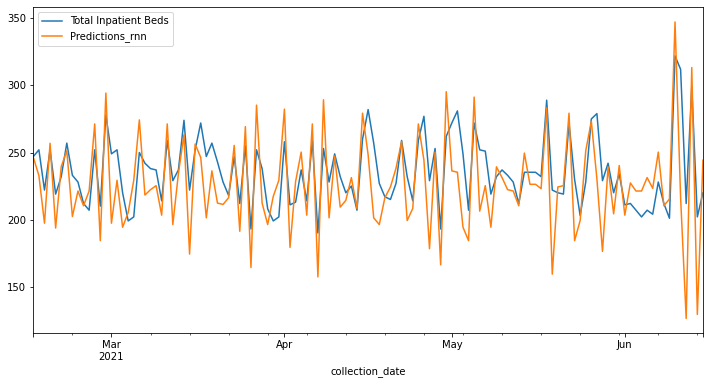

In [93]:
test['Total Inpatient Beds'].plot(legend=True)
test['Predictions_rnn'].plot(figsize=(12,6),legend=True);

In [94]:
rmse(test['Total Inpatient Beds'],test['Predictions_rnn'])

27.38422256346902

In [434]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [435]:
mean_absolute_percentage_error(test['Total Inpatient Beds'],test['Predictions'])

12.032839146393183

<AxesSubplot:xlabel='Total Inpatient Beds'>

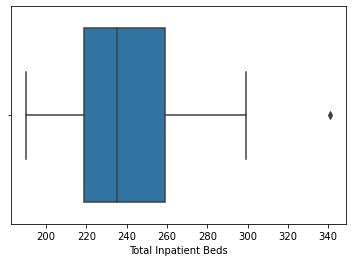

In [436]:
sns.boxplot(train['Total Inpatient Beds'])